# 01 — Exploratory Data Analysis

Goal: Get a solid understanding of the data before doing any modeling. Looking at distributions, missing data patterns, correlations, and how features relate to the outcome.

Covers:
1. Data loading and structure
2. Outcome distribution
3. Feature distributions
4. Correlation heatmap
5. Key features vs outcome
6. Missingness patterns
7. Outlier detection using clinical reference ranges

Figures are loaded from pre-computed pipeline outputs for reproducibility.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from src.config import DATA_FILE, FIGURES_DIR, TABLES_DIR, CLINICAL_RANGES

sns.set_theme(style='whitegrid', font_scale=1.1)
pd.set_option('display.max_columns', 30)
print('Setup complete.')

Setup complete.


## 1. Data Loading & Structure

We begin by loading the raw synthetic dataset (8,000 patients) and inspecting its shape, dtypes, and summary statistics.

In [2]:
df = pd.read_csv(DATA_FILE)
print(f'Dataset shape: {df.shape}')
print(f'\nColumn dtypes:\n{df.dtypes}')
df.head()

Dataset shape: (8000, 17)

Column dtypes:
age                  int64
sex                 object
height_cm          float64
weight_kg          float64
sbp                  int64
dbp                  int64
hba1c              float64
ldl                float64
heart_rate           int64
creatinine         float64
smoking_status      object
exercise_freq      float64
treatment_arm       object
outcome_binary       int64
treatment_cost     float64
downstream_cost    float64
total_cost         float64
dtype: object


,age,sex,height_cm,weight_kg,sbp,dbp,hba1c,ldl,heart_rate,creatinine,smoking_status,exercise_freq,treatment_arm,outcome_binary,treatment_cost,downstream_cost,total_cost
0,62,Male,164.7,59.5,162,89,6.49,84.2,68,1.07,Never,4.0,Standard,0,4952.50,21409.77,26362.28
1,52,Male,166.4,105.4,165,99,7.89,186.4,69,0.96,Never,1.0,Enhanced,0,12562.21,57707.39,70269.59
2,65,Female,163.7,67.8,135,84,6.89,91.3,62,0.90,Never,1.0,Control,1,1473.73,1025.55,2499.28
3,79,Male,183.7,117.9,201,118,7.10,144.5,69,1.18,Never,2.0,Control,0,980.78,19029.32,20010.10
4,51,Female,175.6,56.8,152,92,6.04,82.8,67,0.83,Never,4.0,Control,1,1715.83,2855.11,4570.94


In [3]:
# Summary statistics for numeric features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8000.0,54.501000,15.907549,18.00,44.0000,54.00,65.0000,100.00
height_cm,8000.0,168.797250,9.942349,137.30,161.5000,168.40,175.8250,203.80
weight_kg,8000.0,76.746637,17.773790,30.90,63.9000,74.90,87.1000,158.80
sbp,8000.0,159.039625,15.189294,106.00,149.0000,159.00,169.0000,210.00
dbp,8000.0,93.587500,10.142236,56.00,87.0000,94.00,100.0000,127.00
hba1c,8000.0,6.690270,0.448564,5.40,6.3875,6.65,6.9600,9.41
ldl,7626.0,112.903147,25.545801,30.00,95.5000,113.10,130.2000,202.60
heart_rate,8000.0,67.684375,10.008847,35.00,61.0000,68.00,74.0000,105.00
creatinine,7770.0,0.985124,0.207440,0.57,0.8200,0.97,1.1100,2.37
exercise_freq,7720.0,2.115933,1.241071,0.00,1.0000,2.00,3.0000,7.00


## 2. Outcome Distribution

The target variable `outcome_binary` (1 = good recovery, 0 = poor recovery) has an intentional class imbalance (~33% positive). This reflects real-world healthcare data where treatment success is not always the majority class.

**Business insight:** With ~67% poor outcomes in the control scenario, there is significant room for the predictive model to identify patients who would benefit from enhanced treatment.

Outcome distribution:
outcome_binary
0    5250
1    2750
Name: count, dtype: int64

Positive rate: 34.4%


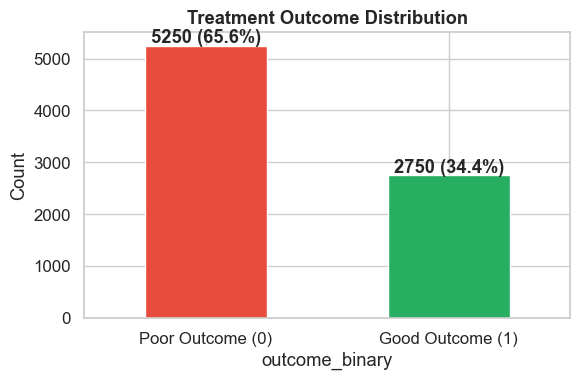

In [4]:
outcome_counts = df['outcome_binary'].value_counts()
print(f'Outcome distribution:\n{outcome_counts}')
print(f'\nPositive rate: {outcome_counts[1] / len(df) * 100:.1f}%')

fig, ax = plt.subplots(figsize=(6, 4))
outcome_counts.plot(kind='bar', color=['#e74c3c', '#27ae60'], ax=ax)
ax.set_xticklabels(['Poor Outcome (0)', 'Good Outcome (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Treatment Outcome Distribution', fontweight='bold')
for i, v in enumerate(outcome_counts):
    ax.text(i, v + 50, f'{v} ({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Feature Distributions

We examine the distributions of all numeric features. Key observations:
- **Age:** Roughly normal, centered around 55 years
- **HbA1c:** Slightly right-skewed (diabetic patients have higher values)
- **Blood pressure:** SBP and DBP follow expected clinical distributions
- **Exercise frequency:** Right-skewed (many patients exercise infrequently)

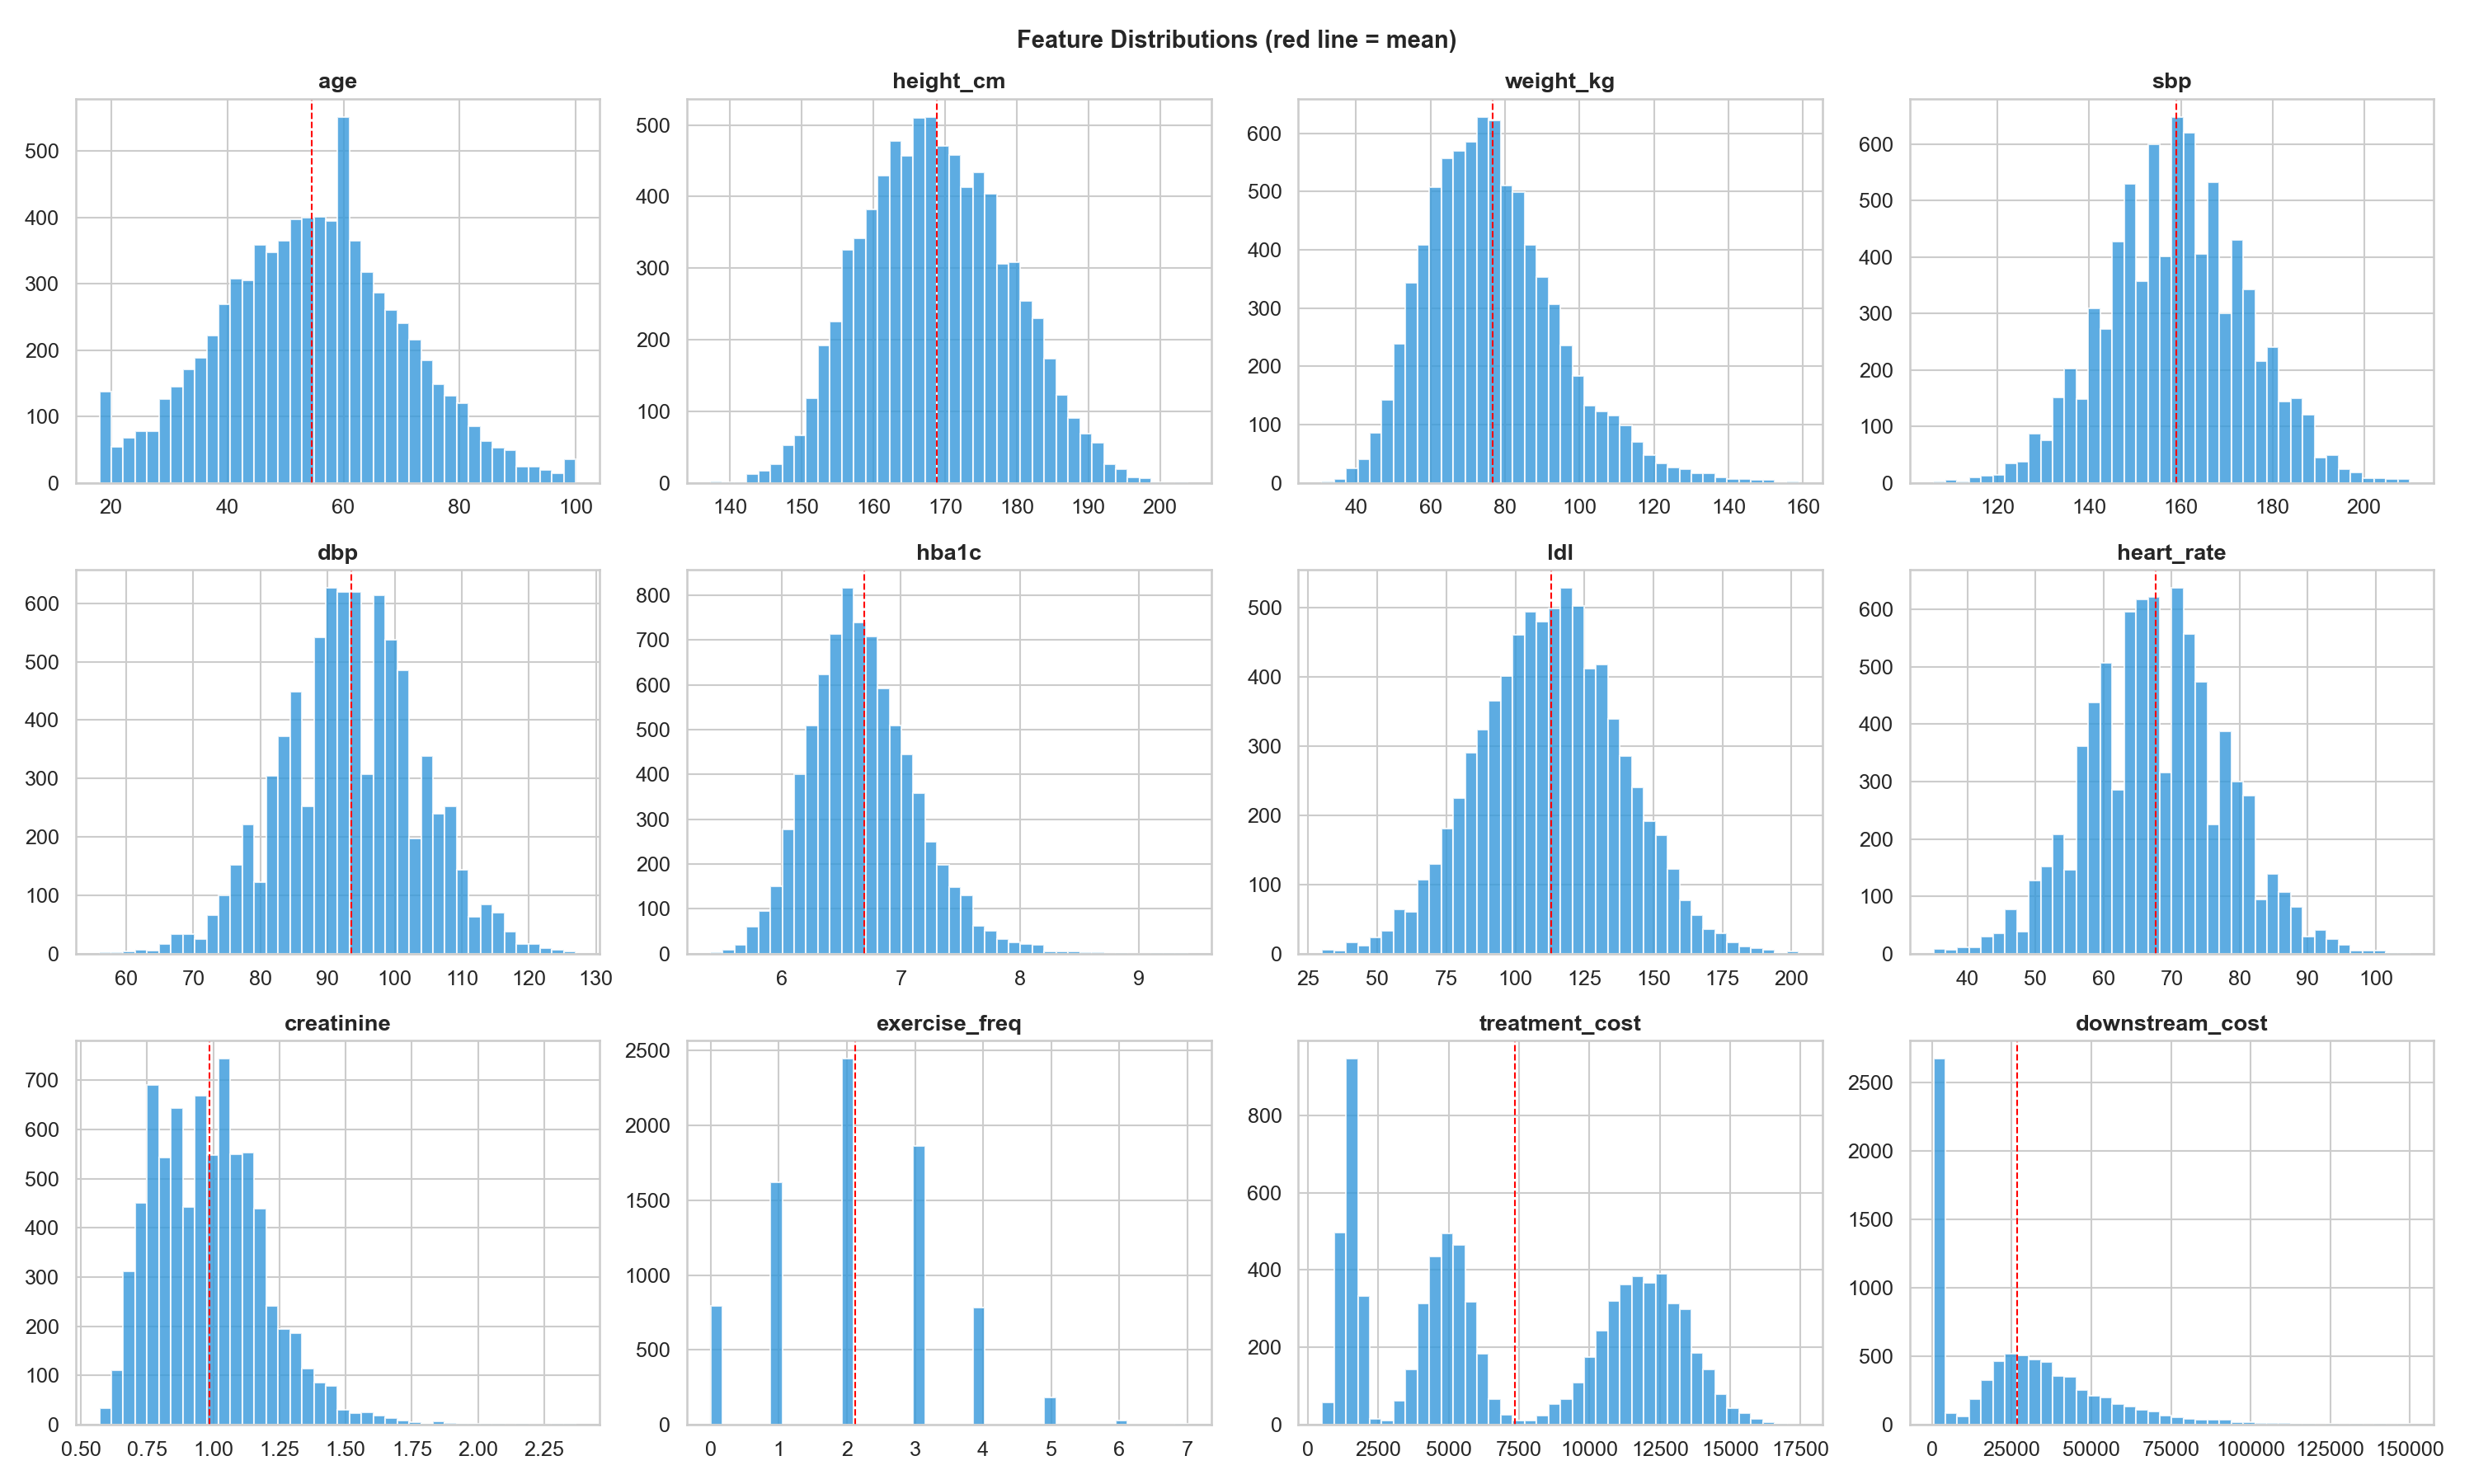

In [5]:
# Pre-computed feature distribution plots
dist_fig = os.path.join(FIGURES_DIR, 'feature_distributions.png')
if os.path.exists(dist_fig):
    display(Image(filename=dist_fig, width=900))
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    for i, col in enumerate(numeric_cols[:12]):
        ax = axes[i // 4, i % 4]
        df[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
        ax.set_title(col, fontweight='bold')
    plt.suptitle('Feature Distributions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 4. Correlation Heatmap

The correlation matrix reveals the linear relationships between features. We expect:
- Strong correlation between SBP and DBP (same physiological system)
- Moderate correlation between weight and BMI
- Weak correlation between unrelated features (e.g., height and HbA1c)

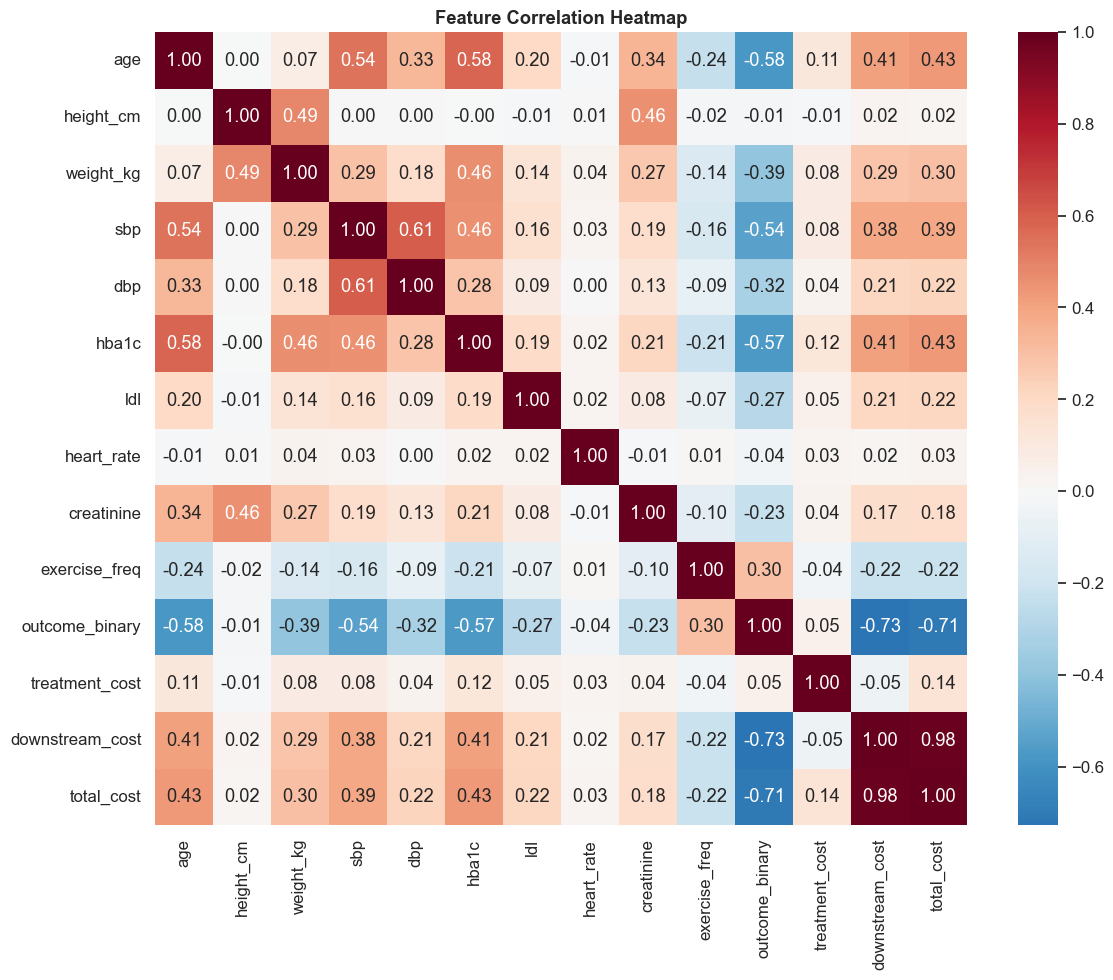

In [6]:
corr_fig = os.path.join(FIGURES_DIR, 'correlation_heatmap.png')
if os.path.exists(corr_fig):
    display(Image(filename=corr_fig, width=800))
else:
    corr = df.select_dtypes(include=[np.number]).corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax)
    ax.set_title('Feature Correlation Heatmap', fontweight='bold')
    plt.tight_layout()
    plt.show()

## 5. Outcome vs. Key Clinical Features

**Clinical insight:** Patients with higher BMI and smoking habits show lower recovery probability. Younger patients and those with controlled HbA1c tend to have better outcomes.

**Business insight:** These findings suggest that targeted lifestyle interventions (smoking cessation, exercise programs) could improve treatment efficacy and reduce costs.

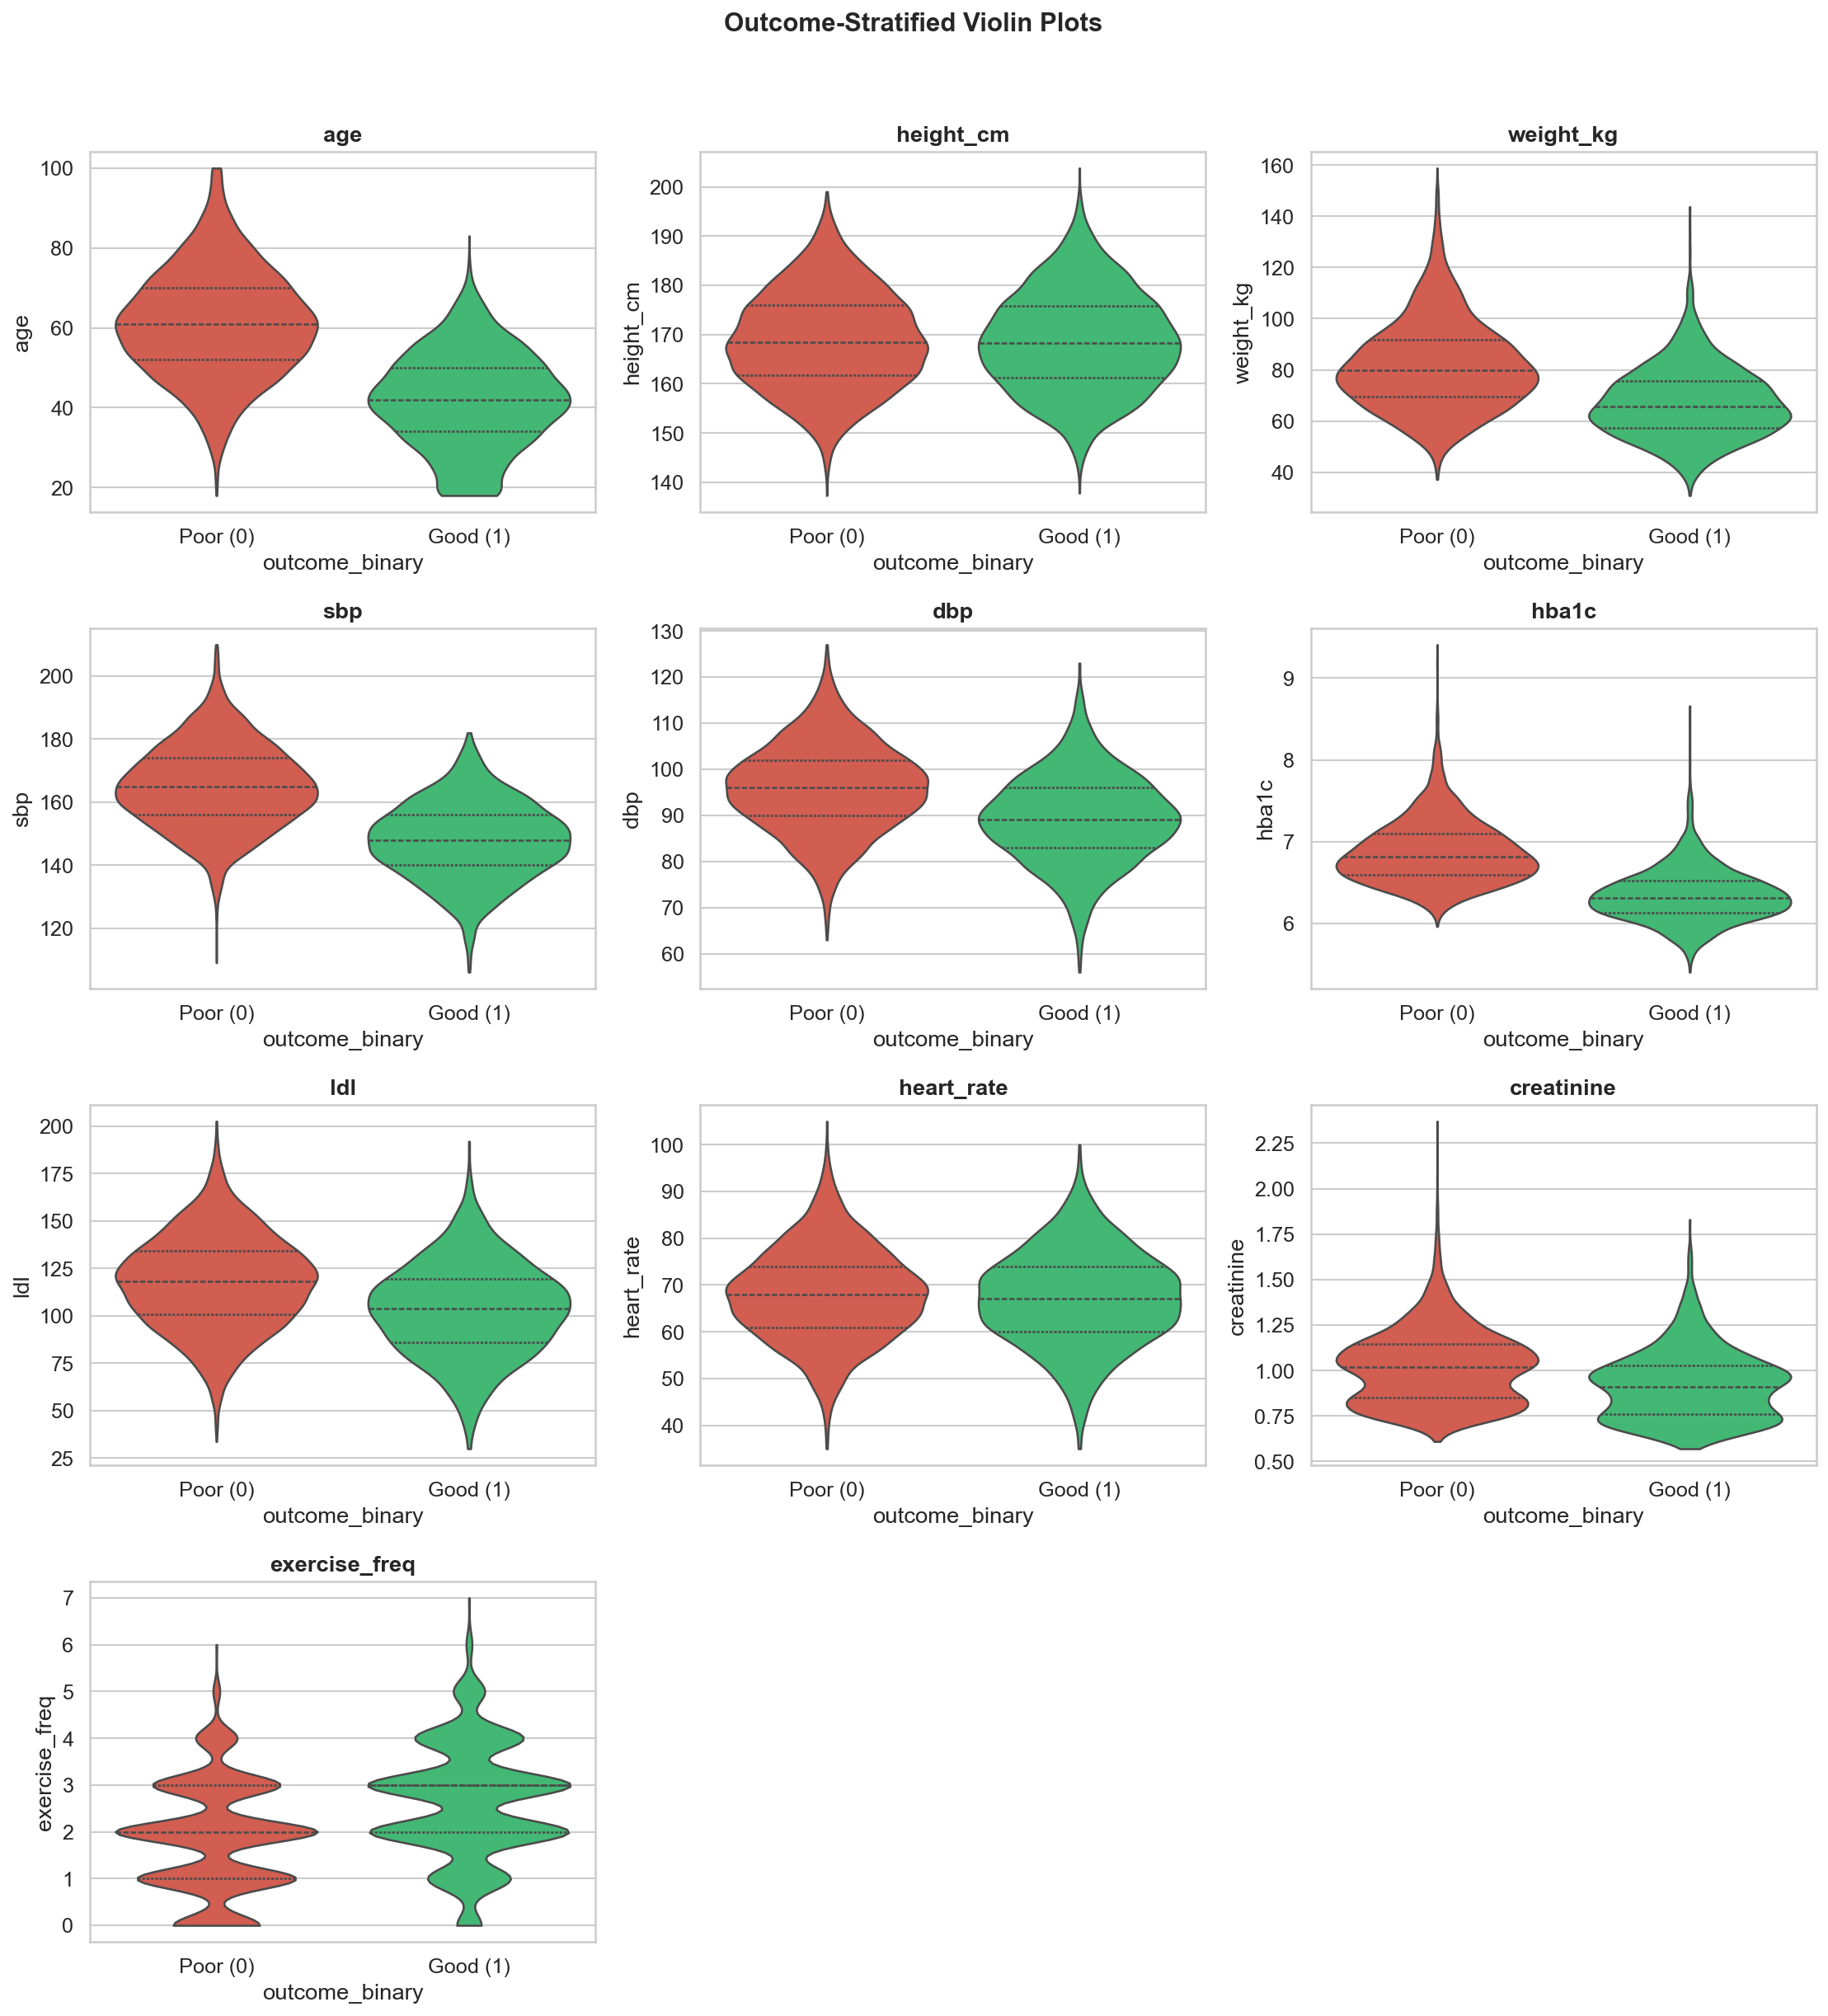

In [7]:
# Outcome-stratified distributions (violin plots)
violin_fig = os.path.join(FIGURES_DIR, 'violin_by_outcome.png')
if os.path.exists(violin_fig):
    display(Image(filename=violin_fig, width=900))
else:
    key_features = ['age', 'hba1c', 'sbp', 'weight_kg', 'exercise_freq', 'creatinine']
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, col in enumerate(key_features):
        ax = axes[i // 3, i % 3]
        for outcome, color in zip([0, 1], ['#e74c3c', '#27ae60']):
            subset = df[df['outcome_binary'] == outcome][col].dropna()
            ax.hist(subset, bins=30, alpha=0.5, color=color, label=f'Outcome={outcome}')
        ax.set_title(col, fontweight='bold')
        ax.legend(fontsize=8)
    plt.suptitle('Feature Distributions by Outcome', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 6. Missingness Analysis

Missing data is introduced as **Missing At Random (MAR)** to simulate real clinical data collection. Key findings:
- LDL cholesterol has the highest missingness rate (~15%) — reflects that blood panels are not always ordered
- Creatinine has moderate missingness (~8%) — renal function tests are condition-dependent
- Demographic features (age, sex) have no missing values

We handle missingness with **MICE imputation** (see notebook 03) because it preserves the multivariate structure better than simple mean/median fill.

Features with missing values:


,missing_count,missing_pct
ldl,374,4.68
exercise_freq,280,3.50
creatinine,230,2.88


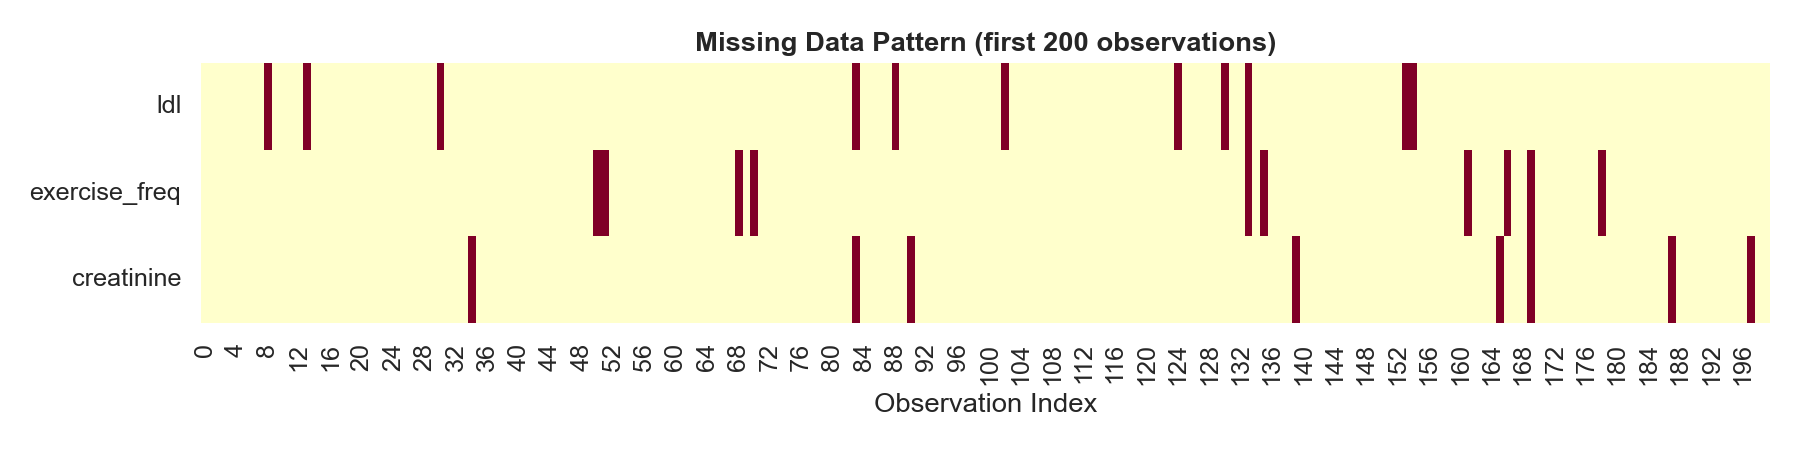

In [8]:
# Missingness report
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_pct', ascending=False)
print('Features with missing values:')
display(missing_df)

# Missingness pattern visualization
miss_fig = os.path.join(FIGURES_DIR, 'missingness_heatmap.png')
if os.path.exists(miss_fig):
    display(Image(filename=miss_fig, width=800))

## 7. Clinical Outlier Detection

We use **clinical reference ranges** (not purely statistical IQR) to identify outliers. Values outside clinically plausible ranges are treated with **Winsorization** — capping at the clinical boundary rather than deleting the patient record.

**Why Winsorization over deletion:** Deleting outlier patients would introduce selection bias and reduce our sample size. Capping at clinical limits preserves the sample while ensuring values remain medically plausible.

In [9]:
# Clinical reference ranges and outlier counts
print('Clinical Reference Ranges:')
for feature, (lo, hi) in CLINICAL_RANGES.items():
    if feature in df.columns:
        n_below = (df[feature] < lo).sum()
        n_above = (df[feature] > hi).sum()
        print(f'  {feature:15s}: [{lo:6.1f}, {hi:6.1f}]  '
              f'below={n_below}, above={n_above}')

# IQR-based outlier detection for comparison
from src.preprocessing import detect_outliers_iqr
outlier_report = detect_outliers_iqr(df)
print('\nIQR-based Outlier Report:')
display(outlier_report)

Clinical Reference Ranges:
  age            : [  18.0,  100.0]  below=0, above=0
  height_cm      : [ 120.0,  220.0]  below=0, above=0
  weight_kg      : [  30.0,  250.0]  below=0, above=0
  sbp            : [  70.0,  250.0]  below=0, above=0
  dbp            : [  40.0,  150.0]  below=0, above=0
  hba1c          : [   3.5,   15.0]  below=0, above=0
  ldl            : [  30.0,  400.0]  below=0, above=0
  heart_rate     : [  35.0,  200.0]  below=0, above=0
  creatinine     : [   0.3,   12.0]  below=0, above=0



IQR-based Outlier Report:


,lower_bound,upper_bound,n_outliers,pct_outliers
age,12.50,96.50,40.0,0.50
height_cm,140.01,197.31,9.0,0.11
weight_kg,29.10,121.90,130.0,1.62
sbp,119.00,199.00,61.0,0.76
dbp,67.50,119.50,90.0,1.12
hba1c,5.53,7.82,128.0,1.60
ldl,43.45,182.25,52.0,0.65
heart_rate,41.50,93.50,80.0,1.00
creatinine,0.38,1.55,91.0,1.14
exercise_freq,-2.00,6.00,3.0,0.04


## Summary

| Finding | Clinical Significance | Implication |
|---------|----------------------|-------------|
| ~33% positive outcome rate | Treatment success isn't guaranteed | Room for the model to add value |
| Higher BMI -> worse outcomes | Obesity complicates recovery | Weight management could improve ROI |
| Smoking reduces recovery rate | Tobacco interferes with healing | Smoking cessation as co-intervention |
| Age strongly predicts outcome | Age-related physiological decline | Consider age-stratified protocols |
| HbA1c clearly separates groups | Glycemic control matters | Pre-treatment glucose optimization |

These findings feed directly into the feature engineering and hypothesis testing in the next notebooks.